<a href="https://colab.research.google.com/github/ManDes71/Rakuten_Text_Classification_TensorFlow/blob/main/notebooks/Modele_RNN_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Google Colab -> Cette cellule est à executer (1 fois) pour le cloner le dépot en local***  
il est possible que google colab vous demande re demarrer la session

In [1]:
!git clone https://github.com/ManDes71/Rakuten_Text_Classification_TensorFlow.git

Cloning into 'Rakuten_Text_Classification_TensorFlow'...
remote: Enumerating objects: 598, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 598 (delta 196), reused 132 (delta 126), pack-reused 364
Receiving objects: 100% (598/598), 42.40 MiB | 6.94 MiB/s, done.
Resolving deltas: 100% (391/391), done.
Updating files: 100% (33/33), done.


**Google Colab -> Cette cellule est à executer (2 fois) pour installer les bibliothèques nécessaires**  
You must restart the runtime in order to use newly installed versions.

In [1]:
import sys
sys.path.append('/content/Rakuten_Text_Classification_TensorFlow')
!pip install -r /content/Rakuten_Text_Classification_TensorFlow/requirements.txt

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from keras.optimizers import SGD,Adam
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout

from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer,accuracy_score,classification_report
import nltk
import re
from sklearn import svm
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import swifter

# set the max columns to none
pd.set_option('display.max_columns', None)

In [3]:
MAXLEN = 600
NUM_WORDS = 70000
EMBEDDING_DIM = 200

In [4]:
import configparser
import sys
#sys.path.append('../src')
sys.path.append('/content/Rakuten_Text_Classification_TensorFlow/src')
import Bibli_DataScience_3_3 as ds
config = configparser.ConfigParser()
config.read('Rakuten_config_colab.ini')

section :  ['DOSSIER', 'FICHIER']


[]

In [5]:


import pandas as pd

# lecture des données sources d'entrainement
df_feats=pd.read_csv(ds.get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(ds.get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

# récupération du fichier df_langue.csv
df_langue=pd.read_csv(ds.get_RACINE_DOSSIER() + 'df_langue.csv')
df=df.merge(df_langue.drop(['Unnamed: 0','prdtypecode'], axis=1),on='Id',how='inner')

Lcat=df_target.sort_values(by='prdtypecode')['prdtypecode'].unique()


nomenclature=pd.read_csv(ds.get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']

#
stopwordFR = pd.read_csv(ds.get_RACINE_DOSSIER() + 'stopwords_FR_02.csv')
stop_words = stopwordFR['MOT'].tolist()
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
df_feats

,Unnamed: 0,designation,description,productid,imageid
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786
...,...,...,...,...,...
84911,84911,The Sims [ Import Anglais ],NaN,206719094,941495734
84912,84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883
84913,84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617
84914,84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403


In [7]:
df_target

,Unnamed: 0,prdtypecode
0,0,10
1,1,2280
2,2,50
3,3,1280
4,4,2705
...,...,...
84911,84911,40
84912,84912,2583
84913,84913,2280
84914,84914,1560


In [8]:
import pandas as pd

def combine_description_and_designation(row):
    partie_design = row['designation'] if isinstance(row['designation'], str) else ''
    partie_descrip = row['description'] if isinstance(row['description'], str) else ''
    return partie_design + ' ' + partie_descrip if len(partie_descrip) > 0 else partie_design

# Appliquer la fonction à chaque ligne
df_feats['phrases'] = df_feats.swifter.apply(combine_description_and_designation, axis=1)

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

 ## ETAPE 1 : Passage en minuscule
Dans un premier temps, nous transformons les majuscules en minuscules car les étapes suivantes sont sensibles à la casse
## ETAPE 2: Tokenisation
 Il s’agit de décomposer une phrase, et donc un document, en tokens. Un token est un élément correspondant à un mot ou une ponctuation, cependant de nombreux cas ne sont pas triviaux à traiter :
Les mots avec un trait d’union, exemple : peut être et peut-être qui ont des significations très différentes ;
Les dates et heures qui peuvent être séparées par des points, des slashs, des deux points ;
Les apostrophes ;
Les caractères spéciaux : émoticônes, formules mathématiques.

In [9]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = str(w)
    # Remplacer les entités HTML par des caractères spécifiques ou les supprimer
    replacements = {
        '&eacute;': 'e',
        '&amp;': '',    # Esperluette
        '&lt;': '',     # Inférieur à
        '&gt;': '',     # Supérieur à
        '&quot;': '',   # Guillemet double
        '&apos;': '',   # Apostrophe
        '&nbsp;': '',   # Espace insécable
        '&copy;': '',   # Droit d'auteur
        '&reg;': '',    # Marque déposée
        '&euro;': '',   # Symbole de l'euro
        '&rsquo;': '',
        '&agrave;': 'a',
        '&ccedil;': 'c',
        '&egrave;': 'e',
        '&iacute;': 'i',
        '&ntilde;': 'n',
        '&ouml;': 'o',
    }
    for entity, replacement in replacements.items():
        w = w.replace(entity, replacement)
    w = unicode_to_ascii(w.lower().strip())
    w = w.replace("n°", "??numero??")
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!°]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)
    w = w.replace("? ? numero ? ?", "n°")


    # Suppression des stopwords
    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()

df_feats['WordRNN'] = df_feats['phrases'].swifter.apply(lambda x :preprocess_sentence(x))
df_feats.head()

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

,Unnamed: 0,designation,description,productid,imageid,phrases,WordRNN
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,Olivia: Personalisiertes Notizbuch / 150 Seite...,olivia personalisiertes notizbuch seiten punkt...
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,journal arts n° art marche salon art asiatique...
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,grand stylet ergonomique bleu gamepad nintendo...
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,Peluche Donald - Europe - Disneyland 2000 (Mar...,peluche donald europe disneyland marionnette d...
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,La Guerre Des Tuques Luc a des id&eacute;es de...,guerre tuques luc idees grandeur . veut organi...


## ETAPE 3: Retrait des stopwords
Ensuite, nous retirons les mots appartenant aux stopwords. Il s’agit de listes de mots définies au préalable soit par l’utilisateur soit dans des librairies existantes. Ces listes se composent de mots qui n’apportent aucune information, qui sont en général très courants et donc présents dans la plupart des documents, par exemple : je, nous, avoir (le verbe et ses conjugaisons). La suppression de ces stopwords permet de ne pas polluer les représentations des documents afin qu’elle ne contienne que les mots représentatifs et significatifs. Ce “nettoyage” du texte peut aussi s’accompagner de la suppression d’autres éléments comme les nombres, les dates, la ponctuation etc.

In [10]:
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
nltk.download('stopwords')

# Ajustement de la fonction preprocess_text
def preprocess_text(text):
    try:
        lang = detect(text)
    except:
        lang = "fr"  # Définit le français comme langue par défaut
    #text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Utilise le français comme langue de fallback pour la tokenisation
    tokens = word_tokenize(text, language='french' if lang not in ['en', 'es', 'de', 'nl', 'it', 'ca'] else lang)
    # Définit le français comme langue de fallback pour les stop words
    stop_words = set(stopwords.words({
        'en': 'english',
        'es': 'spanish',
        'de': 'german',
        'nl': 'dutch',
        'it': 'italian',
        'ca': 'french',  # Utilise explicitement le français pour le catalan
        'fr': 'french'
    }.get(lang, 'french')))  # Fallback sur le français pour toute autre langue non spécifiée

    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Supposons df_feats est votre DataFrame et 'concatenated' la colonne à traiter
# Appliquer preprocess_text à chaque valeur de la colonne 'concatenated'
df_feats['tokenized'] = df_feats['WordRNN'].swifter.apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

## ETAPE 4 : Groupement sémantique
Dès lors, nous disposons pour chaque document d’une liste “nettoyée” de mots porteurs de sens et séparés en tokens. Mais un mot peut être écrit au pluriel, au singulier ou avec différents accords et les verbes peuvent être conjugués à différents temps et personnes.
Nous devons donc réduire les différences grammaticales des mots en trouvant des formes communes. Pour ce faire, nous disposons de deux méthodes distinctes :  
La `stemmatisation`, qui ne prend pas en compte le contexte de la phrase  
La `lemmatisation`, qui prend en compte le contexte  
### ETAPE 4.1 : La stemmatisation
La stemmatisation (ou racinisation) réduit les mots à leur radical ou racine.

In [11]:
from nltk.stem.snowball import SnowballStemmer
import string

def preprocess_text(tokens):
     # Détection de la langue
    try:
        lang = detect(' '.join(tokens))
    except:
        lang = "fr"  # Langue par défaut
    # Adaptation des ressources linguistiques en fonction de la langue détectée
    if lang == 'en':
        stop_words = set(stopwords.words('english'))
        stemmer = SnowballStemmer("english")
    elif lang == 'es':
        stop_words = set(stopwords.words('spanish'))
        stemmer = SnowballStemmer("spanish")
    elif lang == 'de':
        stop_words = set(stopwords.words('german'))
        stemmer = SnowballStemmer("german")
    elif lang == 'nl':
        stop_words = set(stopwords.words('dutch'))
        stemmer = SnowballStemmer("dutch")
    elif lang == 'it':
        stop_words = set(stopwords.words('italian'))
        stemmer = SnowballStemmer("italian")
    elif lang == 'ca':
        stop_words = set(stopwords.words('french'))
        stemmer = SnowballStemmer("french")
    else:
        stop_words = set(stopwords.words('french'))
        stemmer = SnowballStemmer("french")

    preprocessed_tokens = []
    for token in tokens:
        # Conversion en minuscules et suppression de la ponctuation
        token = token.lower()
        token = token.translate(str.maketrans('', '', string.punctuation))
        # Stemmisation
        stemmed_token = stemmer.stem(token)
        preprocessed_tokens.append(stemmed_token)

    return preprocessed_tokens


In [12]:
df_feats['stemmised'] = df_feats['tokenized'].swifter.apply(preprocess_text)


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

In [ ]:
df_feats['stemmised']


0        [olivi, personalisiert, notizbuch, seiten, pun...
1        [journal, art, n°, art, march, salon, art, asi...
2        [grand, stylet, ergonom, bleu, gamepad, ninten...
3        [peluch, donald, europ, disneyland, marionnet,...
4        [guerr, tuqu, luc, ide, grandeur, veut, organi...
                               ...                        
84911                               [sim, import, anglais]
84912    [kit, piscin, aci, nevad, deco, pierr, descrip...
84913    [journal, officiel, republ, francais, n°, chan...
84914    [tabl, bass, bois, recuper, massif, bas, blanc...
84915    [gomm, collect, gomm, pinguin, glac, vert, orang]
Name: stemmised, Length: 84916, dtype: object

In [13]:
texts = df_feats['stemmised'].values
categories = df['prdtypecode'].values


In [14]:
X_train, X_test, y_train, y_test = train_test_split(texts, categories, test_size=0.2, random_state=42)

Le word embedding désigne des méthodes d’apprentissage qui permettent de représenter de facon vectorielle les différents mots d’un texte en
capturant leur contexte.  
Modèle:   
j'utilise Word2VEC avec le parametre sg=1 : **Modèle SkipGram**

In [15]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 1500
# Entraînement de Word2Vec
model_w2v = Word2Vec(X_train, vector_size=EMBEDDING_DIM, window=14, min_count=3, workers=4,sg=1)

**Calcul de TF-IDF**  
Le TF-IDF est calculé pour les documents dans X_train. Cela sert à évaluer l'importance d'un mot dans un corpus.

In [16]:
# Calcul de TF-IDF
X_train_str = [' '.join(doc) for doc in X_train]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(X_train_str).toarray()
feature_names = vectorizer.get_feature_names_out()

**Transformation en dictionnaire**  
Le code transforme la matrice TF-IDF en un dictionnaire de scores, ce qui facilite la recherche du score TF-IDF pour chaque mot. C'est une étape nécessaire pour pondérer les vecteurs Word2Vec par l'importance des mots.

In [17]:
# Transformer TF-IDF matrix en dictionnaire
tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0)))

# Fonction pour vérifier si le mot est dans le dictionnaire TF-IDF et obtenir son score
def get_word_tfidf(word):
    return tfidf_scores.get(word, 0)

Les fonctions **get_word_tfidf** et **document_vector** sont utilisées pour filtrer les mots non présents dans le modèle Word2Vec ou sans score TF-IDF, et pour créer un vecteur de document en pondérant et moyennant les vecteurs Word2Vec des mots d'un document.  
Ces fonctions sont essentielles pour préparer les données d'entrée pour le modèle de classification.

In [18]:
def document_vector(word2vec_model, doc):
    # Supprime les mots inconnus et ceux non présents dans TF-IDF
    words = [word for word in doc if word in word2vec_model.wv and word in tfidf_scores]

    if not words:
        return np.zeros(word2vec_model.vector_size)

    # Utilise le score TF-IDF pour pondérer le vecteur Word2Vec de chaque mot
    word_vectors = np.array([word2vec_model.wv[word] * get_word_tfidf(word) for word in words])

    # Calcule la moyenne de ces vecteurs pour obtenir le vecteur du document
    return np.mean(word_vectors, axis=0)


**Préparation des vecteurs pour la classification**   
Les vecteurs de documents pour les ensembles d'entraînement et de test sont créés en utilisant la fonction document_vector.  
Cela est nécessaire pour convertir le texte en une forme numérique que le modèle de réseau de neurones peut traiter.

In [19]:
# Création des vecteurs pour les ensembles d'entraînement et de test
X_train_vect = np.array([document_vector(model_w2v, doc) for doc in X_train])
X_test_vect = np.array([document_vector(model_w2v, doc) for doc in X_test])

**Encodage des étiquettes**  
Les étiquettes de catégorie sont encodées deux fois, ce qui est redondant.  
La première instance de l'encodage suffit, et le bloc répété peut être supprimé.

In [20]:
from tensorflow.keras.utils import to_categorical

# Encodage des étiquettes de catégorie
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
y_train_dummy = to_categorical(y_train_encoded)
y_test_dummy = to_categorical(y_test_encoded)

In [21]:

#MAXLEN = 200
num_categories=len(np.unique(categories))

In [22]:
from tensorflow.keras.layers import  Dropout ,Conv1D,Flatten,Bidirectional,GRU,BatchNormalization

In [23]:
X_train_vect.shape

(67932, 1500)

In [24]:
model = Sequential()
# Première couche cachée dense
model.add(Dense(512, activation='relu', input_shape=(EMBEDDING_DIM,)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Deuxième couche cachée dense
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Troisième couche cachée dense (optionnelle, pour complexifier davantage le modèle)
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Couche de sortie
model.add(Dense(num_categories, activation='softmax'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               768512    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [26]:
from tensorflow.keras import callbacks
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=1,
                            mode='min')

In [27]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Entraînement du modèle
training_history = model.fit(X_train_vect, y_train_dummy, epochs=80, validation_split=0.2, callbacks=[lr_plateau])

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test_vect, y_test_dummy)
print(f'Loss: {loss}, Accuracy: {accuracy}')



Epoch 1/80
1699/1699 [==============================] - 23s 12ms/step - loss: 1.6742 - accuracy: 0.5262 - val_loss: 1.1971 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 2/80
1699/1699 [==============================] - 21s 13ms/step - loss: 1.3214 - accuracy: 0.6151 - val_loss: 1.0739 - val_accuracy: 0.6834 - lr: 0.0010
Epoch 3/80
1699/1699 [==============================] - 22s 13ms/step - loss: 1.2310 - accuracy: 0.6382 - val_loss: 1.0289 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 4/80
1699/1699 [==============================] - 21s 13ms/step - loss: 1.1760 - accuracy: 0.6548 - val_loss: 1.0102 - val_accuracy: 0.6990 - lr: 0.0010
Epoch 5/80
1699/1699 [==============================] - 20s 12ms/step - loss: 1.1359 - accuracy: 0.6653 - val_loss: 0.9656 - val_accuracy: 0.7098 - lr: 0.0010
Epoch 6/80
1699/1699 [==============================] - 21s 12ms/step - loss: 1.1095 - accuracy: 0.6707 - val_loss: 0.9466 - val_accuracy: 0.7127 - lr: 0.0010
Epoch 7/80
1699/1699 [========================

In [29]:
# Prédictions du modèle
predictions = model.predict(X_test_vect)

# Conversion des prédictions en indices de classe
y_pred = np.argmax(predictions, axis=1)

# Utilisation de `encoder` pour inverser les transformations et obtenir les étiquettes originales
test_pred_original = encoder.inverse_transform(y_pred)

# Affichage des étiquettes inversées
print(test_pred_original)


531/531 [==============================] - 2s 4ms/step
[2905 1281 2060 ... 2585 2522 1320]


In [30]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
tloss = training_history.history['loss']
tvalloss=training_history.history['val_loss']

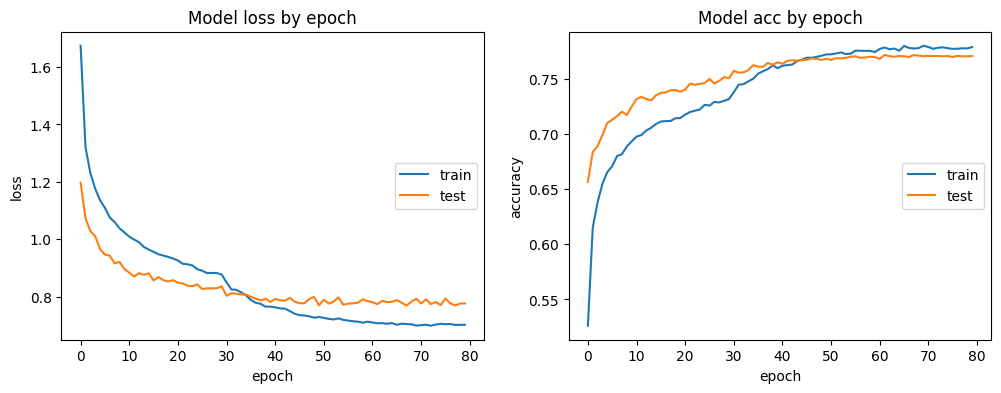

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tloss)
plt.plot(tvalloss)
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')



plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

### Rapport de classification

In [32]:

y_test_original=y_test
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test_original, test_pred_original)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test_original, test_pred_original)))

Précision de la prédiction: 76.46019783325482 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.42      0.39      0.40       612
          40       0.65      0.57      0.61       521
          50       0.80      0.75      0.77       357
          60       0.91      0.86      0.89       161
        1140       0.67      0.74      0.70       539
        1160       0.72      0.85      0.78       786
        1180       0.53      0.47      0.50       146
        1280       0.64      0.63      0.64       961
        1281       0.60      0.39      0.48       424
        1300       0.86      0.91      0.88       974
        1301       0.88      0.89      0.89       169
        1302       0.74      0.72      0.73       507
        1320       0.78      0.70      0.74       672
        1560       0.78      0.78      0.78      1013
        1920       0.87      0.93      0.89       841
        1940       0.76      0.8

In [33]:
df_test = pd.DataFrame({
    'tokenized': X_test,  # Assurez-vous que cela reflète ce que vous voulez montrer; ici, 'X_test' est utilisé comme exemple
    'prdtypecode': y_test,
    'predict': test_pred_original
})

df_test.head()

,tokenized,prdtypecode,predict
0,"[pro, racing, jeu, telecharg, propos, jeu, nkp...",2905,2905
1,"[exit, tombeau, pharaon, class, rte, exit, jeu...",1281,1281
2,"[bricolag, lettr, mouss, argent, alphabet, aut...",2060,2060
3,"[nostalg, fer, blanc, clockwork, chain, jouet,...",1280,1280
4,"[courri, unesco, mai, n°, silenc]",2280,2280


### Tableau des 5 classes les plus prédites pour chaque classe réélle

In [34]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    print(df_test[df_test['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.387255
2280    0.223856
2403    0.114379
2705    0.083333
1160    0.063725
Name: proportion, dtype: float64
40    ------    jeux video pour pc et consoles
predict
40      0.571977
10      0.074856
1160    0.071017
2280    0.055662
1281    0.038388
Name: proportion, dtype: float64
50    ------     accesoires jeux video
predict
50      0.745098
2462    0.070028
40      0.030812
1280    0.025210
1140    0.022409
Name: proportion, dtype: float64
60    ------    consoles de jeux video
predict
60      0.863354
2462    0.074534
40      0.018634
50      0.018634
2905    0.006211
Name: proportion, dtype: float64
1140    ------    produits derives “geeks” et figurines
predict
1140    0.742115
1160    0.057514
1280    0.035250
40      0.020408
1180    0.020408
Name: proportion, dtype: float64
1160    ------    cartes collectionables
predict
1160    0.847328
2280    0.033079
10      0.024173
40      0.017812
1180    0.010178
Name: proportion, dtype: float64

In [35]:
top5_df = pd.DataFrame({'prdtypecode':y_test_original ,'predict': test_pred_original})

df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')
top5_df.head()

,prdtypecode,predict
0,2905,2905
1,1281,1281
2,2060,2060
3,1280,1280
4,2280,2280


In [36]:
df_pred = pd.DataFrame()
for c in Lcat:
            s = df_cross.loc[c].sort_values(ascending=False)[:5]
            df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
            df_pred = pd.concat([df_pred, df_temp], ignore_index=True)

### Tableau des repartitions des **classes prédites** pour chaque **classe réelle**


In [37]:
df_pred

,Categorie,predict,pourc,predict2,pourc2,predict3,pourc3
0,10,10,0.387255,2280,0.223856,2403,0.114379
1,40,40,0.571977,10,0.074856,1160,0.071017
2,50,50,0.745098,2462,0.070028,40,0.030812
3,60,60,0.863354,2462,0.074534,50,0.018634
4,1140,1140,0.742115,1160,0.057514,1280,0.035250
5,1160,1160,0.847328,2280,0.033079,10,0.024173
6,1180,1180,0.465753,1160,0.102740,1140,0.095890
7,1280,1280,0.631634,1300,0.094693,1140,0.074922
8,1281,1281,0.393868,1280,0.290094,1160,0.042453
9,1300,1300,0.908624,1280,0.027721,2280,0.016427


### Tableau croisé

In [38]:
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1281,1300,1301,1302,1320,1560,1920,1940,2060,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,0.387255,0.049020,0.001634,0.000000,0.009804,0.063725,0.009804,0.006536,0.008170,0.009804,0.001634,0.000000,0.004902,0.003268,0.000000,0.004902,0.001634,0.000000,0.223856,0.114379,0.001634,0.008170,0.000000,0.000000,0.004902,0.083333,0.001634
40,0.074856,0.571977,0.038388,0.003839,0.017274,0.071017,0.013436,0.021113,0.038388,0.001919,0.000000,0.003839,0.003839,0.000000,0.000000,0.003839,0.001919,0.000000,0.055662,0.013436,0.034549,0.003839,0.001919,0.001919,0.001919,0.013436,0.007678
50,0.002801,0.030812,0.745098,0.005602,0.022409,0.014006,0.000000,0.025210,0.005602,0.011204,0.000000,0.019608,0.008403,0.011204,0.000000,0.000000,0.002801,0.002801,0.002801,0.000000,0.070028,0.011204,0.000000,0.000000,0.002801,0.000000,0.005602
60,0.000000,0.018634,0.018634,0.863354,0.000000,0.006211,0.000000,0.000000,0.006211,0.006211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074534,0.000000,0.000000,0.000000,0.000000,0.000000,0.006211
1140,0.014842,0.020408,0.003711,0.000000,0.742115,0.057514,0.020408,0.035250,0.009276,0.012987,0.001855,0.003711,0.003711,0.001855,0.001855,0.001855,0.009276,0.000000,0.016698,0.016698,0.003711,0.011132,0.001855,0.001855,0.001855,0.001855,0.003711
1160,0.024173,0.017812,0.001272,0.000000,0.008906,0.847328,0.010178,0.002545,0.010178,0.003817,0.001272,0.005089,0.001272,0.001272,0.000000,0.000000,0.000000,0.000000,0.033079,0.007634,0.001272,0.003817,0.002545,0.000000,0.006361,0.008906,0.001272
1180,0.006849,0.041096,0.013699,0.000000,0.095890,0.102740,0.465753,0.061644,0.054795,0.000000,0.006849,0.000000,0.013699,0.006849,0.006849,0.006849,0.020548,0.000000,0.034247,0.020548,0.013699,0.006849,0.000000,0.013699,0.006849,0.000000,0.000000
1280,0.015609,0.017690,0.006243,0.001041,0.074922,0.011446,0.004162,0.631634,0.021852,0.094693,0.001041,0.031217,0.013528,0.006243,0.002081,0.002081,0.011446,0.001041,0.011446,0.006243,0.002081,0.014568,0.004162,0.004162,0.004162,0.005203,0.000000
1281,0.030660,0.037736,0.007075,0.000000,0.033019,0.042453,0.021226,0.290094,0.393868,0.009434,0.009434,0.025943,0.007075,0.002358,0.000000,0.002358,0.007075,0.002358,0.016509,0.000000,0.004717,0.028302,0.000000,0.000000,0.002358,0.018868,0.007075


### Tableau des 5 classes les plus prédites pour chaque classe réélle avec libellés

In [39]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    s=df_cross.loc[c].sort_values(ascending=False)[:5]
    for index, value in s.items():
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")

10    ------    livres
  : 10,  : 38.73 % , livres
  : 2280,  : 22.39 % , magazines
  : 2403,  : 11.44 % , livres et bds
  : 2705,  : 8.33 % , bds et livres
  : 1160,  : 6.37 % , cartes collectionables
40    ------    jeux video pour pc et consoles
  : 40,  : 57.2 % , jeux video pour pc et consoles
  : 10,  : 7.49 % , livres
  : 1160,  : 7.1 % , cartes collectionables
  : 2280,  : 5.57 % , magazines
  : 50,  : 3.84 % ,  accesoires jeux video
50    ------     accesoires jeux video
  : 50,  : 74.51 % ,  accesoires jeux video
  : 2462,  : 7.0 % , consoles de jeux video et jeux videos
  : 40,  : 3.08 % , jeux video pour pc et consoles
  : 1280,  : 2.52 % , jouets, peluches, poupees
  : 1140,  : 2.24 % , produits derives “geeks” et figurines
60    ------    consoles de jeux video
  : 60,  : 86.34 % , consoles de jeux video
  : 2462,  : 7.45 % , consoles de jeux video et jeux videos
  : 50,  : 1.86 % ,  accesoires jeux video
  : 40,  : 1.86 % , jeux video pour pc et consoles
  : 2905,  : 0.6

### Matrice de confusion

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_original, test_pred_original)
print(cm[:10,:10])
print('*************************************************')
print(cm[10:20,10:20])
print('*************************************************')
print(cm[20:,20:])

[[237  30   1   0   6  39   6   4   5   6]
 [ 39 298  20   2   9  37   7  11  20   1]
 [  1  11 266   2   8   5   0   9   2   4]
 [  0   3   3 139   0   1   0   0   1   1]
 [  8  11   2   0 400  31  11  19   5   7]
 [ 19  14   1   0   7 666   8   2   8   3]
 [  1   6   2   0  14  15  68   9   8   0]
 [ 15  17   6   1  72  11   4 607  21  91]
 [ 13  16   3   0  14  18   9 123 167   4]
 [  9   2   1   0   8   6   3  27   1 885]]
*************************************************
[[151   7   1   1   2   0   0   0   0   0]
 [  3 364  13   5   2   0   4   2   1   3]
 [  3   8 470  18  17   2  34   5   9   3]
 [  1   6  16 786  42   1  72   0   2   0]
 [  0   0  16  12 778   0  25   0   1   1]
 [  1   0   0   0   0 120   1   0   4   0]
 [  0  20  11  92  38   4 779   1   4   0]
 [  1   1   2   1   2   4   4 141   0   1]
 [  0   2   2   1   2   2   2   0 684  57]
 [  0   0   5   0   2   0   0   1 153 666]]
*************************************************
[[ 222    0    0    1    0    0    1]


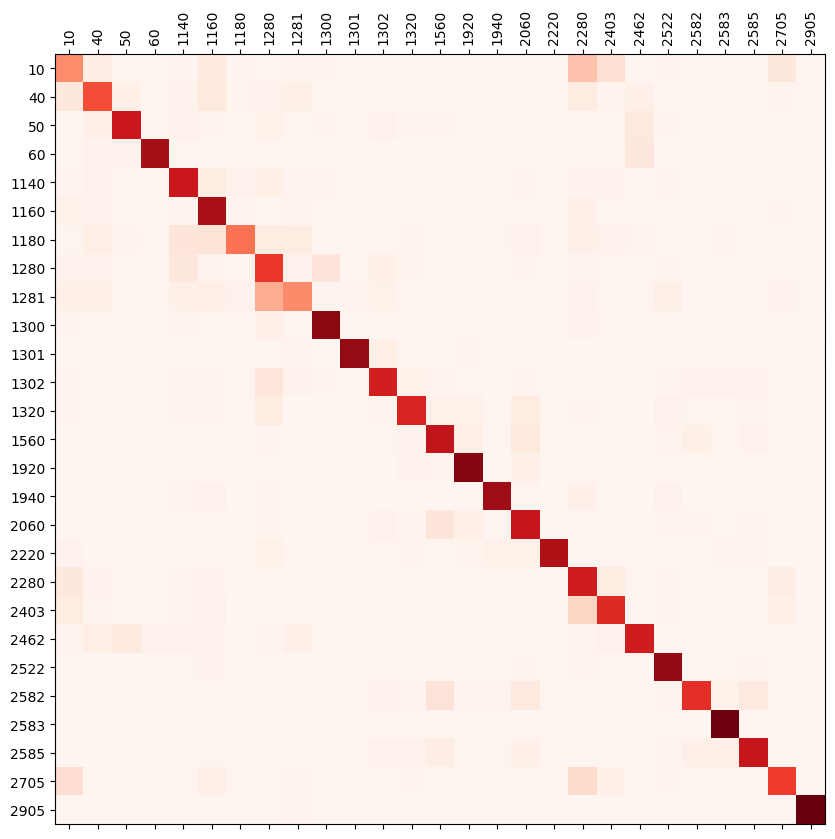

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
#cm_normalized=cm.div(cm.sum(axis=1), axis=0)
cax = ax.matshow(cm_normalized, cmap='Reds')
plt.xticks(range(27),catdict,rotation=90)
plt.yticks(range(27),catdict,rotation=0)
plt.show()

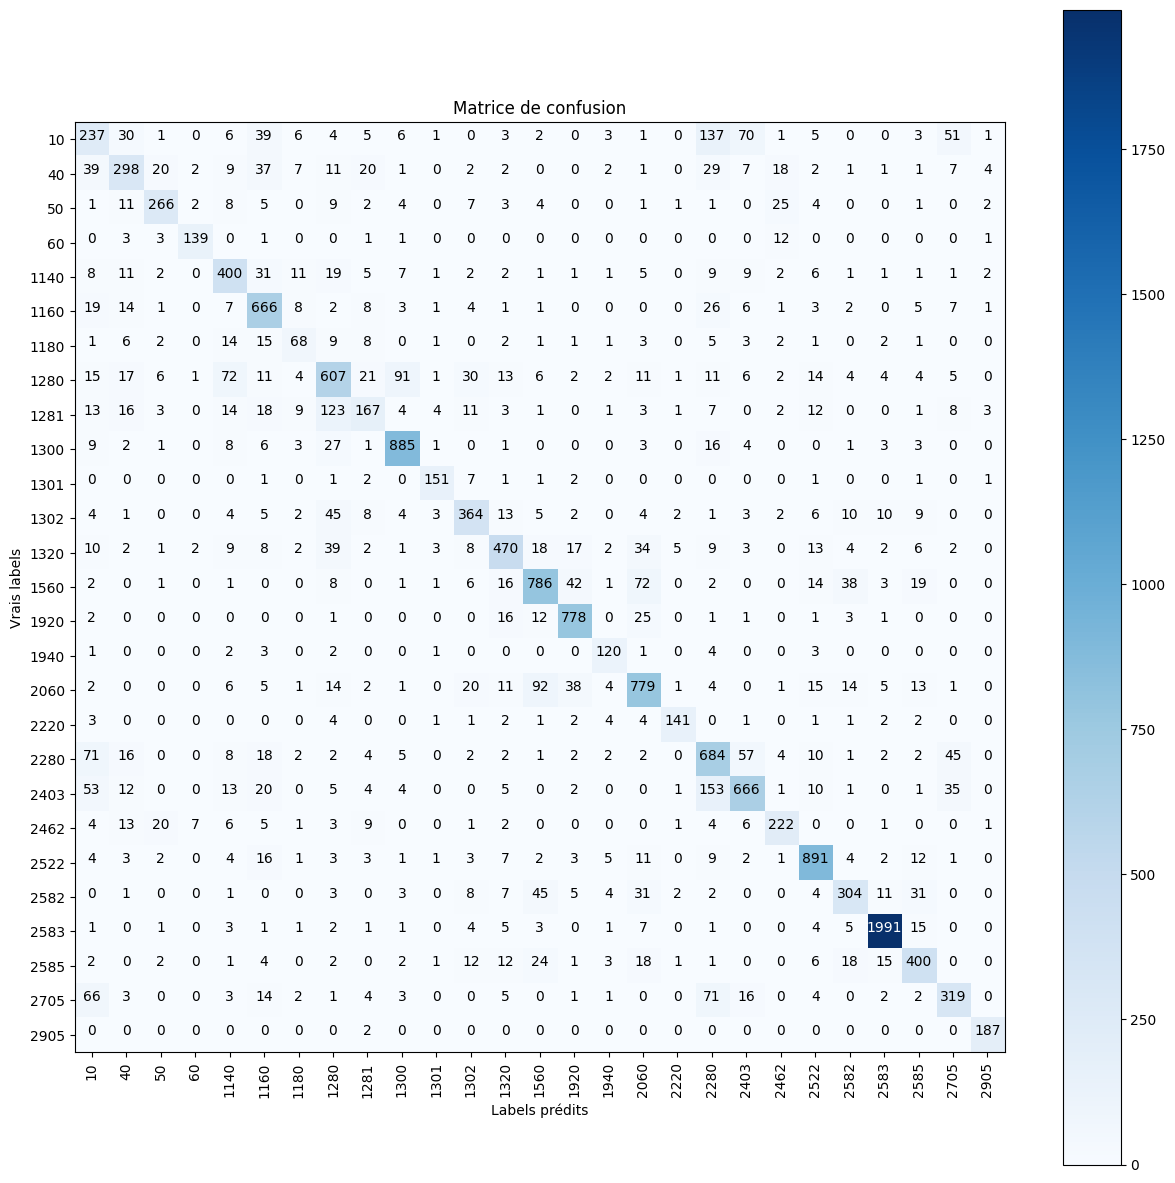

In [42]:
import itertools



# Calcul de la matrice de confusion
cnf_matrix = confusion_matrix(y_test_original, test_pred_original, labels=sorted(list(set(y_test_original))))

# Définition des classes
classes = sorted(list(set(y_test_original)))

# Création et configuration de la figure
plt.figure(figsize=(15, 15))
plt.imshow(cnf_matrix, interpolation='nearest', cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()

# Configuration des ticks
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

# Annotation de chaque cellule de la matrice de confusion
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > (cnf_matrix.max() / 2) else "black")

# Labels pour les axes
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')

# Affichage de la matrice de confusion
plt.show()


## Etude des catégories 10 ; 2280 ; 2403 ; 2705

In [43]:
df_livres=df_test[df_test['prdtypecode'].isin([10,2280,2403,2705])]


In [44]:
print(df_livres.info())
df_livres.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3057 entries, 4 to 16979
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tokenized    3057 non-null   object
 1   prdtypecode  3057 non-null   int64 
 2   predict      3057 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 95.5+ KB
None


,tokenized,prdtypecode,predict
4,"[courri, unesco, mai, n°, silenc]",2280,2280
6,"[parisien, magazin, mar]",2280,2280
9,"[douz, sign, zodiaqu, tout, leur, splendeur, c...",2705,2705
16,"[scen, n°, henr, acte, luig, pirandello, adapt...",2280,2280
23,"[grand, larouss, encycloped, dix, volum]",2403,2403


### Tableau des 5 classes les plus prédites pour chaque classe réélle

In [45]:

for c in [10,2280,2403,2705]:
    print(c,'   ------   ', catdict[c] )
    print(df_livres[df_livres['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.387255
2280    0.223856
2403    0.114379
2705    0.083333
1160    0.063725
Name: proportion, dtype: float64
2280    ------    magazines
predict
2280    0.726115
10      0.075372
2403    0.060510
2705    0.047771
1160    0.019108
Name: proportion, dtype: float64
2403    ------    livres et bds
predict
2403    0.675456
2280    0.155172
10      0.053753
2705    0.035497
1160    0.020284
Name: proportion, dtype: float64
2705    ------    bds et livres
predict
2705    0.617021
2280    0.137331
10      0.127660
2403    0.030948
1160    0.027079
Name: proportion, dtype: float64


### Répartition des 20 mots les plus présents sur l'ensemble de ces catégories

In [46]:
import pandas as pd
from collections import Counter

# Étape 1 : Identifier les 20 mots les plus fréquents
all_words = sum(df_livres['tokenized'].tolist(), [])
global_word_counts = Counter(all_words)
top_20_words = global_word_counts.most_common(20)

# Étape 2 : Calculer le nombre d'occurrences de chaque mot pour chaque classe et globalement
# Initialiser les données pour le DataFrame
data = {"Word": [word for word, count in top_20_words], "Total": [count for word, count in top_20_words]}
class_ids = df_livres['prdtypecode'].unique()

# Calculer les occurrences par classe pour chaque mot
for class_id in class_ids:
    data[class_id] = []
    for word, _ in top_20_words:
        word_count = sum(row.count(word) for row in df_livres[df_livres['prdtypecode'] == class_id]['tokenized'])
        data[class_id].append(word_count)

# Étape 3 : Créer le DataFrame
df_word_counts = pd.DataFrame(data)
df_word_counts.set_index("Word", inplace=True)

# Afficher le DataFrame
print(df_word_counts)
df_total_livres=df_word_counts


         Total  2280  2705  2403  10
Word                                
n°         955   768     1   155  31
lot        393     3     0   390   0
livr       328     4    89   198  37
tom        252    20    56   132  44
franc      243    97    72    48  26
vi         201    32   124    25  20
cet        189     4   179     0   6
mond       186    59   101    20   6
grand      171    36    97    26  12
histoir    146    24    64    36  22
revu       145    60     2    77   6
edit       144    10    16    77  41
anne       140    24    46    52  18
homm       139    13   109    12   5
volum      120     3    12    93  12
entre      117    11    91     8   7
journal    115    66    20    26   3
nouvel     112    32    64    10   6
collect    112    13    26    53  20
guerr      104    33    42    19  10


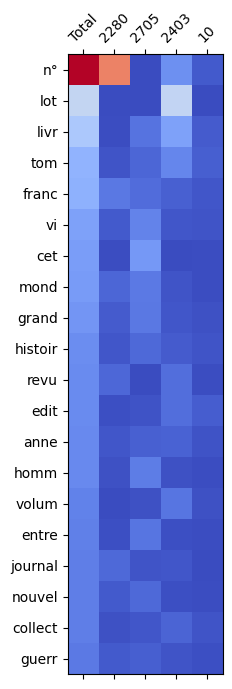

In [47]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_livres.iloc[0:20], cmap = 'coolwarm')
plt.xticks(range(5),(df_total_livres.columns.tolist()),rotation=45)
plt.yticks(range(20),df_total_livres.iloc[0:20].index,rotation=0)
plt.show()

## Etude des catégories 1280,1281

In [48]:
df_jouets=df_test[df_test['prdtypecode'].isin([1280,1281])]

### Tableau des 5 classes les plus prédites pour chaque classe réélle

In [49]:
for c in [1280,1281]:
    print(c,'   ------   ', catdict[c] )
    print(df_jouets[df_jouets['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

1280    ------    jouets, peluches, poupees
predict
1280    0.631634
1300    0.094693
1140    0.074922
1302    0.031217
1281    0.021852
Name: proportion, dtype: float64
1281    ------    jeux de societe/cartes
predict
1281    0.393868
1280    0.290094
1160    0.042453
40      0.037736
1140    0.033019
Name: proportion, dtype: float64


### Répartition des 20 mots les plus présents sur l'ensemble de ces catégories

In [50]:
import pandas as pd
from collections import Counter

# Étape 1 : Identifier les 20 mots les plus fréquents
all_words = sum(df_jouets['tokenized'].tolist(), [])
global_word_counts = Counter(all_words)
top_20_words = global_word_counts.most_common(20)

# Étape 2 : Calculer le nombre d'occurrences de chaque mot pour chaque classe et globalement
# Initialiser les données pour le DataFrame
data = {"Word": [word for word, count in top_20_words], "Total": [count for word, count in top_20_words]}
class_ids = df_jouets['prdtypecode'].unique()

# Calculer les occurrences par classe pour chaque mot
for class_id in class_ids:
    data[class_id] = []
    for word, _ in top_20_words:
        word_count = sum(row.count(word) for row in df_jouets[df_jouets['prdtypecode'] == class_id]['tokenized'])
        data[class_id].append(word_count)

# Étape 3 : Créer le DataFrame
df_word_counts = pd.DataFrame(data)
df_word_counts.set_index("Word", inplace=True)

# Afficher le DataFrame
df_word_counts
df_total_livres=df_word_counts
df_word_counts

,Total,1281,1280
Word,,,
enfant,1503,482,1021
jouet,1128,298,830
cadeau,588,167,421
taill,585,116,469
beb,530,163,367
couleur,517,150,367
toy,444,104,340
jeu,401,228,173
grand,401,130,271


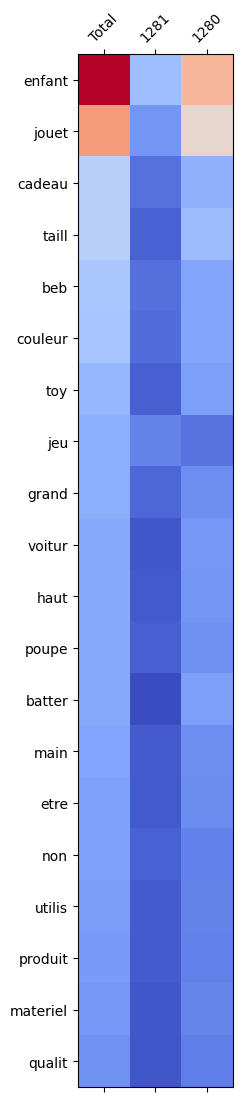

In [51]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_livres.iloc[0:20], cmap = 'coolwarm')
plt.xticks(range(3),(df_total_livres.columns.tolist()),rotation=45)
plt.yticks(range(20),df_total_livres.iloc[0:20].index,rotation=0)
plt.show()